In [43]:
# Importing required libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import onnxmltools
import onnxruntime as ort
from onnxmltools.convert.common.data_types import FloatTensorType

In [45]:
from google.colab import drive
drive.mount('/content/drive')

# Listing files in the HDE folder to confirm the presence of data.db file
print(os.listdir('/content/drive/My Drive/HDE'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data.db', 'DE_notebook.ipynb']


In [47]:
# Create a SQL connection to the SQLite database 'data'

db_path = '/content/drive/My Drive/HDE/data.db'  #local db file location
conn = sqlite3.connect(db_path)
print("Successfully connected to SQLite")

Successfully connected to SQLite


In [48]:
# To fetch all tables from the data.db file
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)

,name
0,homes
1,motion


The database file _data_ includes two tables: `'homes'` and `'motion'`. Next we will load these tables into Python dataframes named `df_homes` and `df_motion`, respectively.


In [49]:
df_homes = pd.read_sql_query("SELECT * from homes", conn)
print(f"df_homes dimension: {df_homes.shape}")
df_homes.head(3)

df_homes dimension: (106, 2)


,id,multiple_occupancy
0,dc922bd9bf8a2a9437642fe0dce9dcaa,0
1,d40fc88629271da7b5833ed3f3222d17,1
2,3fb064da180f02862063eca8e3b609c0,1


In [50]:
df_homes['id'].isnull().sum()

0

The __`df_homes`__ dataframe includes 106 records and two columns: `'id'` and `'multiple_occupancy'`.

 The `'id'` contains 106 unique values, and has no NULL values, ensuring complete data.

 The `'multiple_occupancy'` column is the target variable. It contains binary values: 0 signifies a single occupant, while 1 indicates multiple occupants.

In [51]:
df_motion = pd.read_sql_query("SELECT * from motion", conn)
print(f"df_motion dimension: {df_motion.shape}")
df_motion.head(3)

df_motion dimension: (580317, 4)


,id,home_id,datetime,location
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00,lounge
1,92d48d869ae50b0764cfb8d70494f618,7d2f2e0a9e059b4fb8106bb0ad4b8a39,2024-01-01 00:00:17+00,lounge
2,65c18ba64884442dd47c2fd4cf3630e4,44a880cc6fc3a7db3464092f650ae7f1,2024-01-01 00:00:18+00,lounge


In [52]:
df_motion['location'].value_counts(dropna=True)
# The house structure appears to be a one-bedroom home with six rooms, including a study, lounge, dining room, and conservatory, along with a spacious hallway.

location
kitchen         158415
lounge          153080
hallway          97011
bedroom1         75433
bathroom1        49507
dining room      17053
WC1              10723
conservatory      7715
study             5845
living room       5535
Name: count, dtype: int64

In [53]:
# Renaming the 'id' column to avoid confusion
df_motion.rename({'id': 'motion_id'}, axis=1, inplace=True)

# To check if all values of 'id' column from df_homes are in df_motion 'home_id' column
df_homes.id.isin(df_motion.home_id).astype(int).sum()

50

In [54]:
# To ensure datetime is in the correct datetime format
df_motion['datetime'] = pd.to_datetime(df_motion['datetime'])

# Printing start and end datetime entries
print(f"Start date: {df_motion['datetime'].min()}")
print(f"End date: {df_motion['datetime'].max()}")
print(f"Month: {df_motion['datetime'].dt.month.unique()}")

Start date: 2024-01-01 00:00:10+00:00
End date: 2024-01-31 23:59:12+00:00
Month: [1]


The __`df_motion`__ dataframe contains a substantial 580,317 records with four columns: `'id'`, `'home_id'`, `'datetime'`, and `'location'`.

The `'home_id'` column contains 50 unique records and seems to be derived from the `'id'` column in the `df_homes` dataframe. However, it only includes 50 of the 106 IDs present in `df_homes`. To avoid confusion with the `'id'` in `df_homes`, we have renamed the `'id'` column in `df_motion` to `'motion_id'`, as it represents unique identifiers for each motion event.

The `'datetime'` column includes entries from January 1st to January 31st, 2024, covering data only for the month of January.

The `'location'` column features 10 unique entries: kitchen, lounge, hallway, bedroom1, bathroom1, WC1, living room, dining room, study, and conservatory.

**Note:** For data modeling purpose in this sheet, we will assume that all motion data is collected from homes with the same structural design.

In [55]:
# Merging df_homes and df_motion dataframes to create base data for analysis

df = pd.merge(df_motion, df_homes, left_on='home_id', right_on='id')
df.head(3)

,motion_id,home_id,datetime,location,id,multiple_occupancy
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00:00,lounge,205c42ec747e2db13cb92087a99433f1,1
1,321d24f5a5210ba1e11f0beb11702e41,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:01:24+00:00,bedroom1,205c42ec747e2db13cb92087a99433f1,1
2,7bdf72b2919d9886691a4a74fc2a3073,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:02:30+00:00,lounge,205c42ec747e2db13cb92087a99433f1,1


After merging the dataframes, the next step is feature engineering. This involves creating additional features to extract more detailed insights from the existing data in the `df` dataframe

**FEATURE ENGINEERING**

In [56]:
# Extracting temporal features

# Fetching day of the week
df['day_of_week'] = pd.to_datetime(df['datetime']).dt.dayofweek

# Checking if the day was a weekend
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Fetching the hour of the day
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

# Counting the number of motions per home
df['motion_count'] = df.groupby('home_id')['motion_id'].transform('count')

In [57]:
# Creating location-based features

# To count the unique locations for each home_id
location_counts = df.groupby('home_id')['location'].nunique().rename('location_diversity')

 # To create columns for each location, with the values representing the counts of occurrences for each home_id-location combination
frequent_locations = df.groupby(['home_id', 'location']).size().unstack(fill_value=0).rename(lambda x: f'loc_{x}', axis=1)

# Merging above features into the main dataframe
df = df.merge(location_counts, on='home_id')
df = df.merge(frequent_locations, on='home_id', how='left')

In [58]:
# Creating activity-intensity features

# To indicate whether there was an activity at more than one location in the house at the same datetime (sdt)
df['sdt_multiple_locations'] = (df.groupby(['home_id', 'datetime'])['location'].transform('nunique') > 1).astype(int)

# To calculate time span between the earliest and latest datetime values for each home_id, expressed in seconds
df['activity_duration'] = df.groupby('home_id')['datetime'].transform(lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).total_seconds())

# To calculate the frequency of motion events relative to the duration of activity
df['motion_frequency'] = df['motion_count'] / df['activity_duration']

In [59]:
# To showcase all the columns in dataframe
pd.options.display.max_columns = None

df.head(3)

,motion_id,home_id,datetime,location,id,multiple_occupancy,day_of_week,is_weekend,hour,motion_count,location_diversity,loc_WC1,loc_bathroom1,loc_bedroom1,loc_conservatory,loc_dining room,loc_hallway,loc_kitchen,loc_living room,loc_lounge,loc_study,sdt_multiple_locations,activity_duration,motion_frequency
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00:00,lounge,205c42ec747e2db13cb92087a99433f1,1,0,0,0,16191,7,480,782,1702,3051,0,1237,3466,0,5473,0,0,2675882.0,0.006051
1,321d24f5a5210ba1e11f0beb11702e41,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:01:24+00:00,bedroom1,205c42ec747e2db13cb92087a99433f1,1,0,0,0,16191,7,480,782,1702,3051,0,1237,3466,0,5473,0,0,2675882.0,0.006051
2,7bdf72b2919d9886691a4a74fc2a3073,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:02:30+00:00,lounge,205c42ec747e2db13cb92087a99433f1,1,0,0,0,16191,7,480,782,1702,3051,0,1237,3466,0,5473,0,0,2675882.0,0.006051


**EXPLORATORY DATA ANALYSIS**

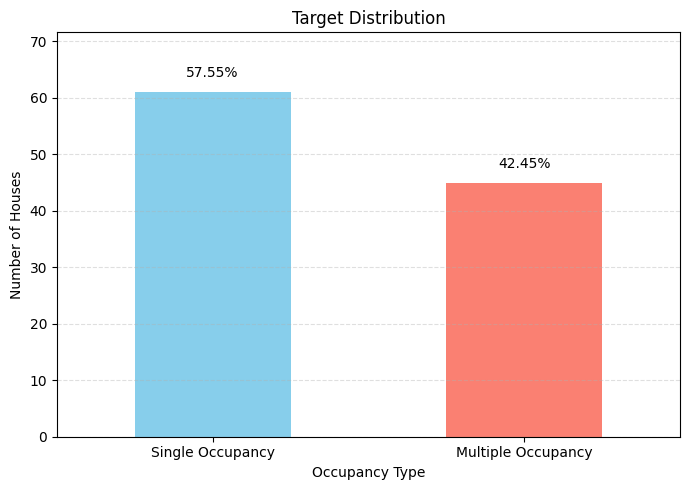

In [62]:
occupancy_counts = df_homes['multiple_occupancy'].value_counts()
total = occupancy_counts.sum()
percentages = (occupancy_counts / total) * 100

# Creating a bar plot
plt.figure(figsize=(7,5))
ax = occupancy_counts.plot(kind='bar', color=['skyblue', 'salmon'], width=0.5)

# Adding titles and labels
plt.title('Target Distribution')
plt.xlabel('Occupancy Type')
plt.ylabel('Number of Houses')
plt.xticks(ticks=[0, 1], labels=['Single Occupancy', 'Multiple Occupancy'], rotation=0)

# Increasing y-axis limit to show percentages comfortably
max_count = occupancy_counts.max()

# Adding some padding above the tallest bar
plt.ylim(0, max_count + 0.1 * total)

# Adding percentage values
for i, (count, percentage) in enumerate(zip(occupancy_counts, percentages)):
    plt.text(i, count + 0.02 * total, f'{percentage:.2f}%',
             ha='center', va='bottom', fontsize=10)

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Comment:** The graph above illustrates the distribution of the target variable, `'multiple_occupancy'`, which will be used for our prediction model. It shows that 57.55% of the homes in the dataset are single occupancy, while 42.45% are multiple occupancy.

Although the data is not perfectly balanced, it is not severely imbalanced either. Therefore, we can proceed with the dataset as it is for the subsequent modeling steps.

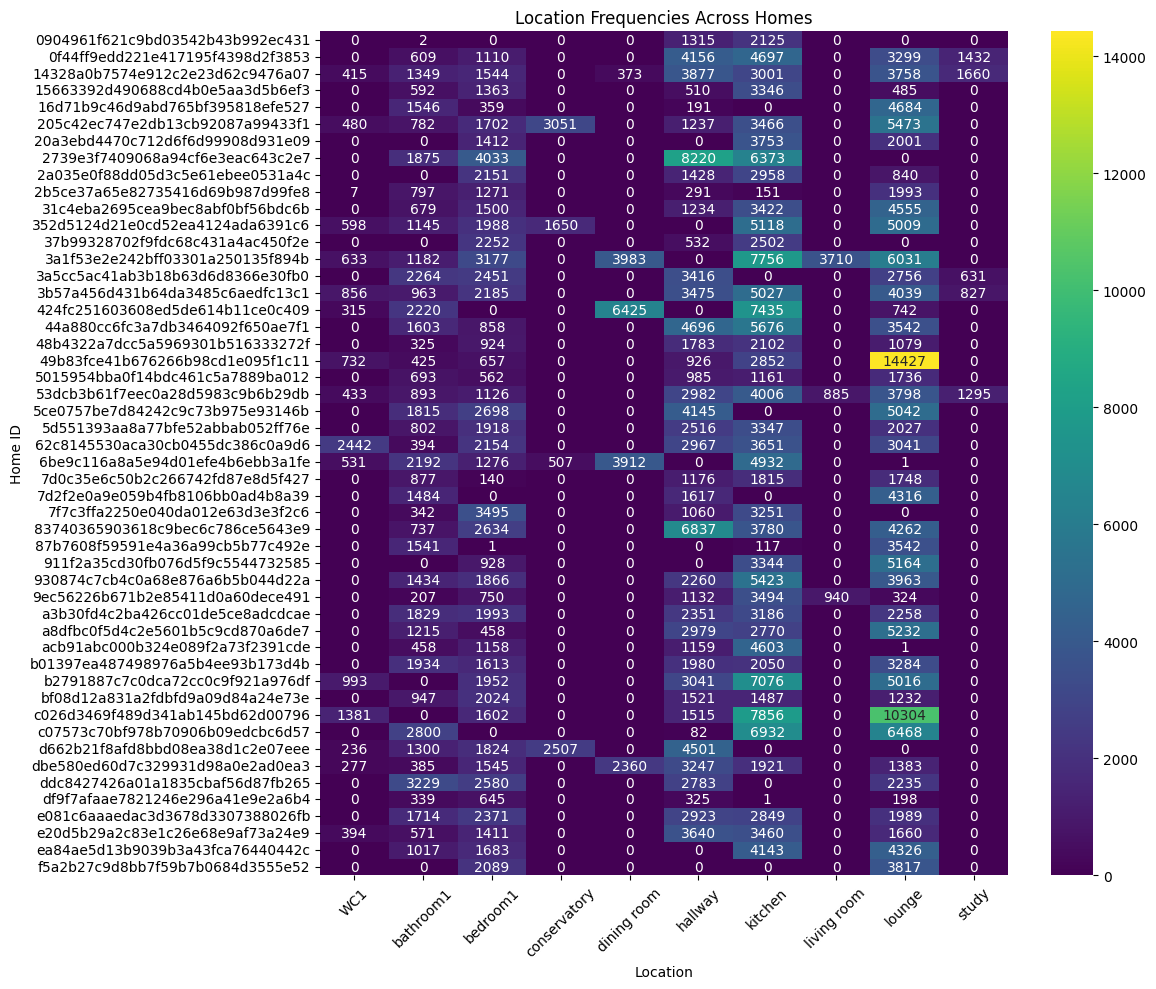

In [63]:
# Count occurrences of each location per home
location_counts = df.groupby(['home_id', 'location']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(location_counts, cmap='viridis', annot=True, fmt='d')
plt.title('Location Frequencies Across Homes')
plt.xlabel('Location')
plt.ylabel('Home ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Comments:** The above heatmap offers some intriguing insights into the dataset. It highlights that certain locations, like the conservatory, dining room, living room, and study, show minimal motion activity. This suggests that these areas might not play a significant role in predicting occupancy, possibly due to insufficient data.

On the contrary, locations with frequent motion, such as the kitchen and lounge, stand out as strong indicators of multiple occupancy. These areas tend to be more actively used regardless of the season (January), which aligns with the presence of multiple occupants in a household.

Moreover, it is highly likely that homes with multiple occupants exhibit motion-activity spread across a wider variety of rooms compared to single-occupant homes.

Considering these initial insights from the heatmap and the correlation matrix (plotted next), it will be worth investigating how different locations contribute to our occupancy prediction model.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   motion_id               580317 non-null  object             
 1   home_id                 580317 non-null  object             
 2   datetime                580317 non-null  datetime64[ns, UTC]
 3   location                580317 non-null  object             
 4   id                      580317 non-null  object             
 5   multiple_occupancy      580317 non-null  int64              
 6   day_of_week             580317 non-null  int32              
 7   is_weekend              580317 non-null  int64              
 8   hour                    580317 non-null  int32              
 9   motion_count            580317 non-null  int64              
 10  location_diversity      580317 non-null  int64              
 11  loc_WC1                 58

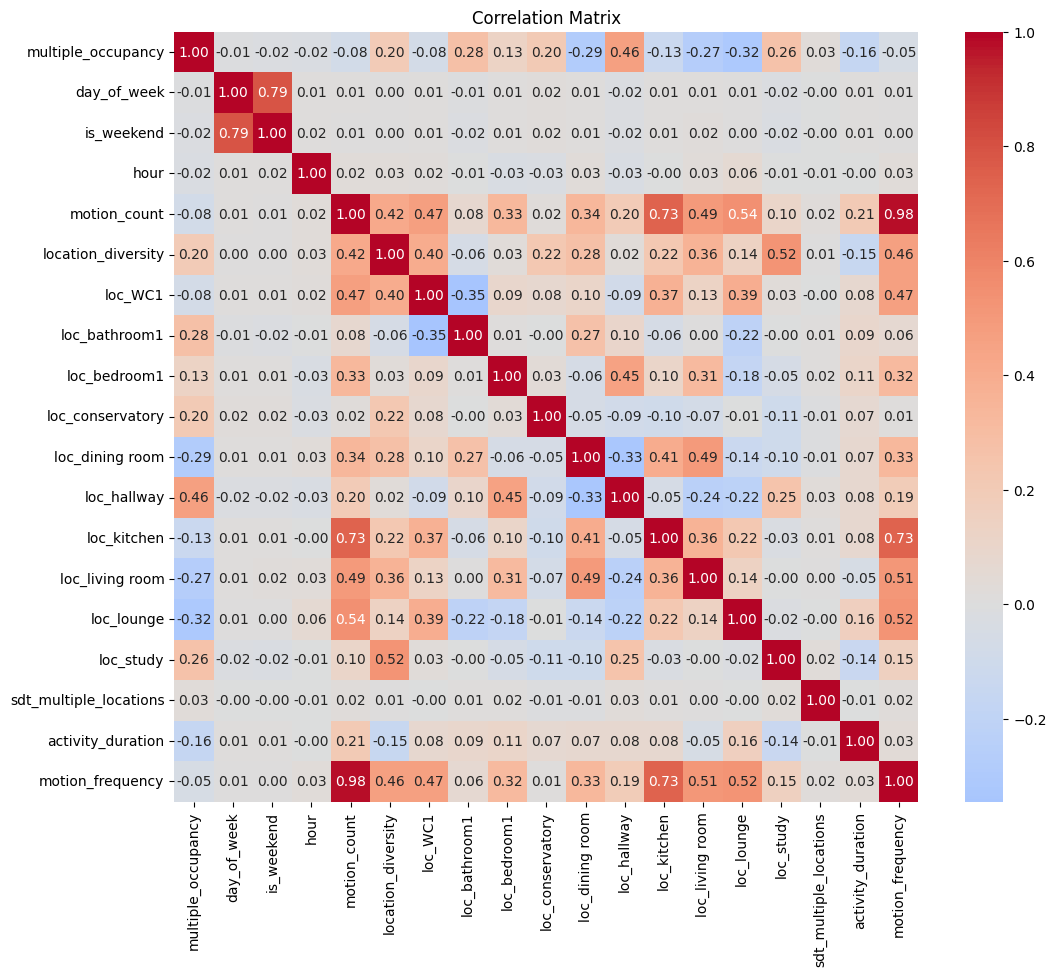

In [65]:
# Correlation matrix- to examine the relationships between features and the target variable

# Dropping all non-numeric columns
df_numeric = df.drop(columns=['motion_id', 'home_id', 'datetime', 'location', 'id'])

# Computing correlation matrix
correlation_matrix = df_numeric.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [66]:
correlation_matrix


,multiple_occupancy,day_of_week,is_weekend,hour,motion_count,location_diversity,loc_WC1,loc_bathroom1,loc_bedroom1,loc_conservatory,loc_dining room,loc_hallway,loc_kitchen,loc_living room,loc_lounge,loc_study,sdt_multiple_locations,activity_duration,motion_frequency
multiple_occupancy,1.000000,-0.010815,-0.015468,-0.019572,-0.080631,0.199485,-0.076429,0.275907,0.132320,0.204974,-0.285797,0.459340,-0.130649,-0.271022,-0.317286,0.261318,0.025366,-0.162927,-0.048813
day_of_week,-0.010815,1.000000,0.791067,0.009495,0.007144,0.001588,0.010699,-0.014136,0.011923,0.019062,0.006990,-0.015696,0.009937,0.014006,0.005102,-0.018743,-0.004293,0.007702,0.005180
is_weekend,-0.015468,0.791067,1.000000,0.015111,0.005614,0.003008,0.008571,-0.018975,0.014023,0.020658,0.008336,-0.019105,0.011121,0.018013,0.003431,-0.023774,-0.004762,0.007758,0.003470
hour,-0.019572,0.009495,0.015111,1.000000,0.024871,0.027185,0.021112,-0.007660,-0.030543,-0.029922,0.026477,-0.033444,-0.001677,0.028995,0.061726,-0.007836,-0.006337,-0.004588,0.026552
motion_count,-0.080631,0.007144,0.005614,0.024871,1.000000,0.417986,0.473870,0.078409,0.334836,0.020726,0.341713,0.200522,0.733826,0.490389,0.542374,0.102632,0.018165,0.207805,0.982634
location_diversity,0.199485,0.001588,0.003008,0.027185,0.417986,1.000000,0.401541,-0.057420,0.031313,0.223529,0.276139,0.023583,0.219695,0.360271,0.140391,0.524160,0.006591,-0.147556,0.464648
loc_WC1,-0.076429,0.010699,0.008571,0.021112,0.473870,0.401541,1.000000,-0.345268,0.092129,0.077128,0.102222,-0.086693,0.370214,0.132838,0.393093,0.027388,-0.001689,0.080054,0.469040
loc_bathroom1,0.275907,-0.014136,-0.018975,-0.007660,0.078409,-0.057420,-0.345268,1.000000,0.009371,-0.000006,0.268259,0.101035,-0.055784,0.004617,-0.217301,-0.000812,0.008032,0.092019,0.064844
loc_bedroom1,0.132320,0.011923,0.014023,-0.030543,0.334836,0.031313,0.092129,0.009371,1.000000,0.033627,-0.058143,0.453620,0.103631,0.312432,-0.176402,-0.053998,0.016640,0.108639,0.318502
loc_conservatory,0.204974,0.019062,0.020658,-0.029922,0.020726,0.223529,0.077128,-0.000006,0.033627,1.000000,-0.053369,-0.086894,-0.098018,-0.074654,-0.007209,-0.105600,-0.010755,0.067826,0.007665


**Comments:** Our target variable for modeling is `'multiple_occupancy'`. Consequently, we will select features that exhibit a strong correlation with this target variable, taking into account the insights from the heatmap analysis.

There 13 chosen primary features are:
- `'is_weekend'`
- `'location_diversity'`
- `'loc_WC1'`
- `'loc_bathroom1'`
- `'loc_bedroom1'`
- `'loc_conservatory'`
- `'loc_dining room'`
- `'loc_hallway'`
- `'loc_kitchen'`
- `'loc_living room'`
- `'loc_lounge'`
- `'activity_duration'`
- `'motion_frequency'`
<br>

Dropping below features- based on weak correlation or multicollinearity:

- `'hour'`
- `'sdt_multiple_locations'`

Intuitively, the `'sdt_multiple_locations'` column, which indicates activities at various locations in a house at the same time, should be useful for predicting `'multiple_occupancy'`. The rationale is that multiple motions across different locations simultaneously suggest the presence of multiple residents in the house. However, the correlation matrix reveals a very different picture that this feature has a very low correlation with the target variable (0.02)! This indicates that, contrary to our intuition, `'sdt_multiple_locations'` may not be a strong predictor of multiple occupancy.

**Handling Multicollinearity:**

- `'motion_count'` and `'loc_kitchen'`: These features are highly correlated (0.73). Since `'motion_count'` has a slightly higher correlation with the target variable (-0.08) compared to `'loc_kitchen'`, we will retain `'motion_count'`.

- `'day_of_week'` and `'is_weekend'`: These features have a high correlation of 0.79. We initially considered choosing `'is_weekend'` because it has a somewhat better relationship with the target variable (-0.015). However, based on common intuition, activity levels might be higher on weekdays compared to weekends, as people tend to go out more during weekends. Nonetheless, considering that January can be quite cold and people might prefer staying indoors, `'is_weekend'` could still be a relevant feature. Therefore, we decided to use `'is_weekend'`

- `'loc_lounge'` and `'loc_study'`: Given that `'loc_lounge'` has a stronger correlation with the target variable (-0.31), we will select `'loc_lounge'`.

However, remembering the golden mantra: *Correlation does not imply causation!* <br> We will assess how these features contribute to the model's ability to predict occupancy.

In [68]:
# Selecting features and target for model training

X = df[['location_diversity', 'loc_WC1', 'loc_bathroom1', 'loc_bedroom1', 'loc_conservatory', 'is_weekend',
               'loc_dining room', 'loc_hallway', 'loc_kitchen','loc_living room', 'loc_lounge',
               'activity_duration', 'motion_frequency']]
y = df['multiple_occupancy']

In [69]:
# Spliting data into 75:25 ratio for training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# XGBoost is not sensitive to the magnitude of variables, so we did not apply any scaling or standardization here

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy Score: 1.0

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     49045
           1       1.00      1.00      1.00     96035

    accuracy                           1.00    145080
   macro avg       1.00      1.00      1.00    145080
weighted avg       1.00      1.00      1.00    145080



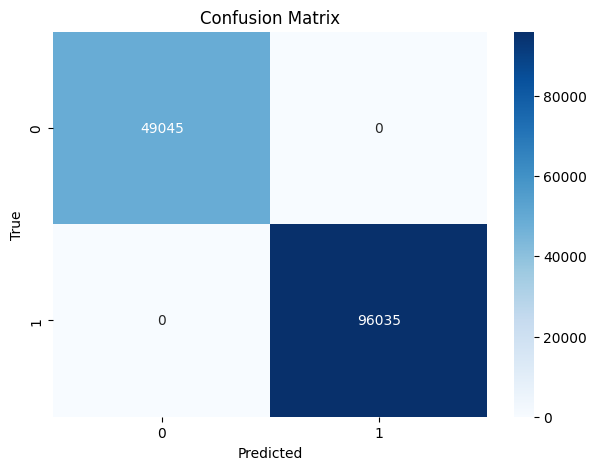

In [70]:
# Initializing and training XGBoost model
xg_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xg_model.fit(X_train, y_train)

# Make predictions
y_pred = xg_model.predict(X_test)

# Evaluate the model
print("XGBoost Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#print("Confusion matrix:\n", conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=xg_model.classes_, yticklabels=xg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Reflections:**

**1. Model Performance:**

- **Accuracy:** The model has achieved perfect accuracy, with all predictions being correctly classified. The accuracy is 100% because there are no false positives (FP) or false negatives (FN).

- **Precision and Recall:** Both precision and recall are also perfect in this case. Precision, which measures the ratio of correctly predicted positives to the total predicted positives, is 100%. Similarly, recall, which measures the ratio of correctly predicted positives to the total actual positives, is also 100%.

**2. Confusion Matrix:**

In this binary classification problem, the confusion matrix reveals:

- **High True Positives (TP):** The model has correctly classified 96,035 instances as positive, indicating excellent performance in identifying positive cases when they are present.
  
- **High True Negatives (TN):** The model has correctly classified 49,045 instances as negative, showing strong performance in recognizing negative cases.

- There are no False Positives (FP) or False Negatives (FN), further underscoring the model's perfect performance.
<br>
<br>

While the results and confusion matrix suggest that the model performs exceptionally well on this dataset, my inner data enthusiast can't help but question the robustness of these findings!

For the next steps, I recommend addressing potential overfitting during training by employing cross-validation techniques to ensure the model’s performance is consistent across different data folds. Additionally, testing the model on edge cases and diverse scenarios will help verify its robustness and generalizability across various situations.




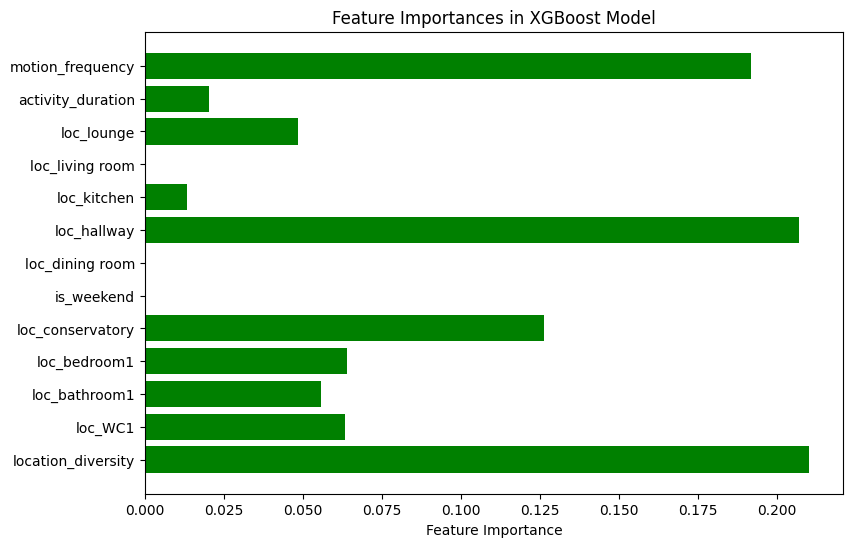

In [71]:
# Plot feature importances
feature_importances = xg_model.feature_importances_
features = X.columns

plt.figure(figsize=(9, 6))
plt.barh(features, feature_importances, color='green')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in XGBoost Model')
plt.show()

Above `Feature Importance` plot provides insights into which features contribute most significantly to the XGBoost model's predictive ability.

**Key Observations:**

- **`'location_diversity'`**: This feature stands out as the most influential, suggesting that the variety of locations where motion is detected plays a crucial role in determining occupancy. Homes with multiple occupants are likely to show activity across a broader range of rooms

- **`'loc_hallway'`**: The hallway emerges as the second most important feature (very close to the `'location_diversity'` feature). This makes sense because the hallway is often the first area encountered when entering a house, and its activity patterns can provide valuable insights into occupancy

- Features such as **`'loc_bedroom1'`, `'loc_lounge'`**, **`'loc_bathroom1'`**, and **`'loc_WC1'`** still contribute to the model’s predictions, though they are less dominant compared to **`'Location Diversity'`** and **`'loc_hallway'`**. The frequency of motion detected in these areas is valuable for understanding occupancy, but their impact is not as pronounced

- **`'loc_lounge'`**: Its contribution to the prediction model is moderate. Although refering back to the heatmap analysis, it showed very high motion-detection activity for nearly every household. This moderate performance in the model indicates that while the feature is frequently active, it does not strongly differentiate between single and multiple occupancy cases in this context

- **Weekend vs. Weekday (`'is_weekend'`)**: This feature shows relatively low importance, indicating that the distinction between weekends and weekdays may not be a strong predictor of multiple occupancy in this dataset

- **`'loc_dining room'` and `'loc_living room'`**: These features exhibit very minimal importance in the model. Refering to the heatmap,  reveals that these columns have motion entries for only a limited number of homes, indicating insufficient data to effectively contribute to the model’s predictions. Their near-zero importance proves that they do not provide significant additional discriminative power beyond what is already captured by other features.

- **`'motion_frequency'`**: This feature holds the third highest importance in predicting occupancy. Its significance implies that the frequency of motion across different locations provides valuable insights into occupancy patterns

- **`'activity_duration'`**: This time-based feature has a relatively low impact on the model's predictions. This suggests that the overall duration of activity might not be as discriminative for determining occupancy compared to the specific locations where motion occurs
<br>
<br>


One of the next steps could be to remove the non-essential features from the model and focus on the most important ones, as identified in the analysis. Building the model with only these key features, as highlighted in the graph above, may improve its performance and interpretability.

**OPTIONAL STEP:**
1. Packing model in ONNX format

In [72]:
# Renaming the feature columns to follow a numeric pattern such as 'f0', 'f1', 'f2', etc.

# Creating a mapping of old names to new names and then renaming
new_column_names = {col: f'f{i}' for i, col in enumerate(X.columns)}
X = X.rename(columns=new_column_names)

# Training XGBoost model
xg_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xg_model.fit(X, y)

# Defining the input type for ONNX conversion
input_type = FloatTensorType([None, X.shape[1]])

# Converting the XGBoost model to ONNX format
onnx_model = onnxmltools.convert_xgboost(xg_model, initial_types=[('input', input_type)])

# Saving the ONNX model
onnxmltools.utils.save_model(onnx_model, 'xgboost_model.onnx')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:08:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


2. Testing the ONNX model

In [73]:
# Loading the above ONNX model
session = ort.InferenceSession('xgboost_model.onnx')

# Preparing input data to match the expected format
input_data = np.array(X_test, dtype=np.float32)
input_name = session.get_inputs()[0].name

# Making predictions
predictions = session.run(None, {input_name: input_data})[0]
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)